In [1]:
import pandas as pd
import logging
import torch
import pytorch_lightning as pl
from pathlib import Path
from torch.utils.data import DataLoader
import seisbench
import seisbench.models as sbm
from seisLM.evaluation import pick_eval
import numpy as np
import matplotlib.pyplot as plt
from seisLM.utils import project_path
from phasepick_model_registry import ckpt_registry, plot_kwargs

/scicore/home/dokman0000/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from ml_collections import config_dict
training_fracs = ['0.05', '0.1', '0.2', '0.5', '1.0']
eval_set = 'test'
# seislm_variant = 'large'

In [3]:
all_datasets_results = {}

for data_name in ['ETHZ', 'GEOFON', 'STEAD']:

  all_training_frac_results = {}

  for train_frac in training_fracs:
    model_result = {}

    for model_name, ckpt_paths in ckpt_registry[data_name].items():

      model_identifier = ckpt_paths[train_frac].split('/')[-3]

      base_pred_path = (
        Path(project_path.EVAL_SAVE_DIR)
        / f"{model_identifier}_{data_name}"
      )

      event_detection_result = pick_eval.get_results_event_detection(
        base_pred_path / f"{eval_set}_task1.csv")

      phase_identification_result = pick_eval.get_results_phase_identification(
        base_pred_path / f"{eval_set}_task23.csv"
      )

      onset_determination_result = pick_eval.get_results_onset_determination(
        base_pred_path / f"{eval_set}_task23.csv"
      )

      model_result[model_name] = {
        'event_detection': event_detection_result,
        'phase_identification': phase_identification_result,
        'onset_determination': onset_determination_result
      }

    all_training_frac_results[train_frac] = model_result

  all_datasets_results[data_name] = all_training_frac_results

/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/evaluation/pick_eval.py:179: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * recall / (prec + recall)
/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/evaluation/pick_eval.py:179: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * recall / (prec + recall)


In [4]:
A4_WIDTH = 8.27
FONT_SIZE = 12

## Task 1

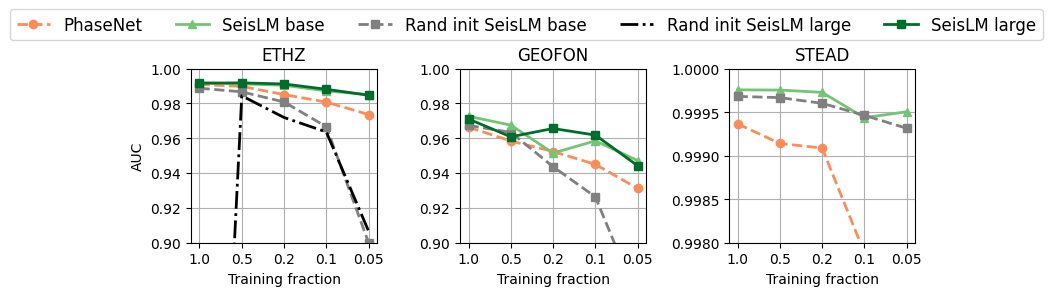

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(A4_WIDTH, A4_WIDTH/ 3 ))  # A4 paper size, width: 8.27 inches, height: 11.69 inches
axes = axes.ravel()  # Flatten the 2x3 array of axes to easily iterate

plt.rcParams.update({
    'font.size': FONT_SIZE,  # General font size
    'axes.titlesize': FONT_SIZE,  # Subplot titles
    'figure.titlesize': FONT_SIZE,  # Suptitle (main title)
    'legend.fontsize': FONT_SIZE,  # Legend font size
    'pdf.fonttype': 42,  # Embed fonts in PDF for better compatibility
})


idx = 0
for data_name, all_training_frac_results in all_datasets_results.items():
  ax = axes[idx]
  for model_name in all_training_frac_results[training_fracs[0]].keys():
    ax.plot(
      training_fracs[::-1],
      [all_training_frac_results[training_frac][model_name]['event_detection']['auc']
      for training_frac in training_fracs[::-1]],
      label=model_name.replace("_", " "),
      ** plot_kwargs[model_name]
    )
  ax.set_xlabel('Training fraction')
  if idx == 0:
    ax.set_ylabel('AUC')
  ax.set_title(data_name)
  ax.grid()

  if idx == 2:
    ax.set_ylim([0.998, 1])
  else:
    ax.set_ylim([0.9, 1])
  # ax.set_yscale('log')
  idx += 1

# Extract handles and labels from the first axis for the legend
handles, labels = axes[0].get_legend_handles_labels()

# Add a single legend at the top of the figure
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.1), frameon=True)


plt.tight_layout()
# plt.suptitle('Event Detection', y=1.15, fontweight='bold')
plt.show()
fig.savefig(
  project_path.FIGURE_DIR + f'/all_datasets_auc_event_detection.pdf',
  bbox_inches='tight'
)


# Task 2

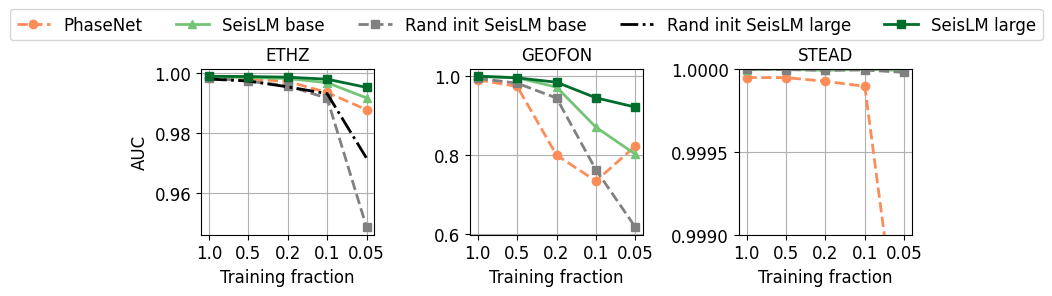

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(A4_WIDTH, A4_WIDTH/ 3 ))  # A4 paper size, width: 8.27 inches, height: 11.69 inches
axes = axes.ravel()  # Flatten the 2x3 array of axes to easily iterate

plt.rcParams.update({
    'font.size': FONT_SIZE,  # General font size
    'axes.titlesize': FONT_SIZE,  # Subplot titles
    'figure.titlesize': FONT_SIZE,  # Suptitle (main title)
    'legend.fontsize': FONT_SIZE,  # Legend font size
    'pdf.fonttype': 42,  # Embed fonts in PDF for better compatibility
})




idx = 0
for data_name, all_training_frac_results in all_datasets_results.items():
  ax = axes[idx]
  for model_name in all_training_frac_results[training_fracs[0]].keys():
    ax.plot(
      training_fracs[::-1],
      [all_training_frac_results[training_frac][model_name]['phase_identification']['auc']
      for training_frac in training_fracs[::-1]],
      label=model_name.replace("_", " "),
      ** plot_kwargs[model_name]
    )
  ax.set_xlabel('Training fraction')
  if idx == 0:
    ax.set_ylabel('AUC')
  ax.set_title(data_name)
  ax.grid()

  if idx == 2:
    ax.set_ylim([0.999, 1])

  idx += 1

# Extract handles and labels from the first axis for the legend
handles, labels = axes[0].get_legend_handles_labels()

# Add a single legend at the top of the figure
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.1), frameon=True)

# plt.suptitle(f'Event detection on {data_name}')
plt.tight_layout()
plt.show()
fig.savefig(
  project_path.FIGURE_DIR + f'/all_datasets_auc_phase_identification.pdf',
  bbox_inches='tight'
)


# Task 3

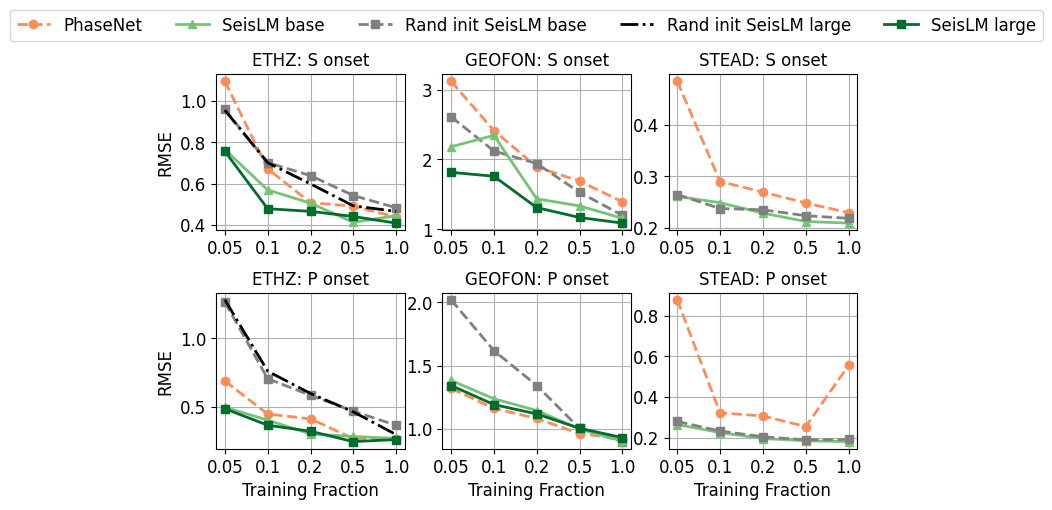

In [9]:
from collections import defaultdict
num_datasets = len(all_datasets_results)


fig, axes = plt.subplots(2, 3, figsize=(A4_WIDTH, A4_WIDTH/ 1.7 ))  # A4 paper size, width: 8.27 inches, height: 11.69 inches
axes = axes.ravel()  # Flatten the 2x3 array of axes to easily iterate

plt.rcParams.update({
    'font.size': FONT_SIZE,  # General font size
    'axes.titlesize': FONT_SIZE,  # Subplot titles
    'figure.titlesize': FONT_SIZE,  # Suptitle (main title)
    'legend.fontsize': FONT_SIZE,  # Legend font size
    'pdf.fonttype': 42,  # Embed fonts in PDF for better compatibility
})





dataset_idx = 0
for data_name, all_training_frac_results in all_datasets_results.items():
  all_models = list(all_training_frac_results['0.05'].keys())

  S_onset_diff_dict = defaultdict(list)
  P_onset_diff_dict = defaultdict(list)


  for model in all_models:
    for frac in training_fracs:
      S_onset_diff_dict[model].append(
        all_training_frac_results[frac][model]['onset_determination']['S_onset_diff'].to_numpy() )
      P_onset_diff_dict[model].append(
        all_training_frac_results[frac][model]['onset_determination']['P_onset_diff'].to_numpy())



  for key, val in S_onset_diff_dict.items():
    axes[dataset_idx].plot(
      training_fracs,
      [np.sqrt(np.mean(onset_diff**2)) for onset_diff in val],
      label=key.replace("_", " "),
      ** plot_kwargs[key]
    )
    axes[dataset_idx].set_title(f'{data_name}: S onset')
  axes[dataset_idx].grid()

  for key, val in P_onset_diff_dict.items():
    axes[dataset_idx + num_datasets].plot(
      training_fracs,
      [np.sqrt(np.mean(onset_diff**2)) for onset_diff in val],
      label=key.replace("_", " "),
      ** plot_kwargs[key]
    )
    axes[dataset_idx + num_datasets].set_title(f'{data_name}: P onset')
    axes[dataset_idx + num_datasets].set_xlabel('Training Fraction')

  axes[dataset_idx + num_datasets].grid()
  axes[0].set_ylabel('RMSE')


  axes[num_datasets].set_ylabel('RMSE')

  dataset_idx += 1


# Extract handles and labels from the first axis for the legend
handles, labels = axes[0].get_legend_handles_labels()
# Add a single legend at the top of the figure
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.03), frameon=True)
plt.subplots_adjust(hspace=0.4)  # You can adjust this value (e.g., 0.5) to increase or decrease the space

# plt.suptitle('Onset Regression', y=1.07, fontweight='bold')

fig.savefig( project_path.FIGURE_DIR + f'/all_datasets_onset_regression.pdf', bbox_inches='tight')
